In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 

In [2]:
path_to_text = 'books_and_authors'
data = pd.read_csv(path_to_text, names=['v1', 'v2'])

label = data['v1']
text = data['v2']

text

0      Pretty soon I wanted to smoke, and asked the w...
1      Her sister, Miss Watson, a tolerable slim old ...
2      Now she had got a start, and she went on and t...
3      Miss Watson she kept pecking at me, and it got...
4      I set down again, a-shaking all over, and got ...
                             ...                        
994    I was on the point of asking him what that wor...
995      1. Knowledge of Literature.--Nil.\n  2.     ...
996    I see that I have alluded above to his powers ...
997    During the first week or so we had no callers,...
998    It was upon the 4th of March, as I have good r...
Name: v2, Length: 999, dtype: object

## TEXT PREPROCESING AND TOKENIZATION

In [3]:
import nltk

nltk.download('omw-1.4')
nltk.download('punkt')

from nltk.corpus import stopwords, wordnet

nltk.download('stopwords')
stopwords_ = stopwords.words('english')

nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
import string

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
text_preprocessed = []

for sentence in text:
    #sentence lower
    sentence = sentence.lower()

    #string punct
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    #tokenize
    tokens = nltk.word_tokenize(sentence)
    
    # stop-words
    tokens_stop_words = []
    
    for token in tokens:
          if token not in stopwords_:
                tokens_stop_words.append(token)
                
    # Lemmatization
    tokens_lemma = []
    for token in tokens_stop_words:
          tokens_lemma.append(wnl.lemmatize(token, get_wordnet_pos(nltk.pos_tag([token])[0][1])))
            
    final = ' '.join(tokens_lemma)
    
    text_preprocessed.append(final)

In [5]:
len(text_preprocessed), len(label)

(999, 999)

## EXTRACTING TEST AND TRAINING DATA

In [6]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(
    text_preprocessed, label, test_size=0.3, random_state=42)


In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

trainY= le.fit_transform(trainY)
testY = le.transform(testY)

trainY.shape,testY.shape
trainY[0]

3

In [8]:
decodedY = le.inverse_transform([0,1,2,3,4,5,6])
decodedY

array(['Arthur Conan Doyle', 'Charles Dickens', 'Edgar Allan Poe',
       'George Eliot', 'Jack London', 'Jane Austin', 'Mark Twain'],
      dtype=object)

### EMBEDING WITH COUNT VECTORIZER


In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# Count Vectors as features
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=5000)
count_vect.fit(text_preprocessed)

# transform the training and test data using count vectorizer object
trainX_vec = count_vect.transform(trainX)
testX_vec = count_vect.transform(testX)

trainX_vec.shape,
testX_vec.shape

(300, 5000)

In [86]:
dict_ = count_vect.vocabulary_
new_data = pd.DataFrame.from_dict(dict_, orient='index')

### COUNT VECTORIZER WITH LOGISTIC REGRESSION

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#create an instance of the model
lr_model = LogisticRegression(random_state=7, C=1, max_iter = 500) #pomalo C se poloshi, pogolemo isto poloshi
#train the model
lr_model.fit(trainX_vec, trainY)

#predict test data
pred_test = lr_model.predict(testX_vec)

#print evaluation metrics 
print(classification_report(testY,pred_test))
print(confusion_matrix(testY,pred_test))
print("Accuracy:", accuracy_score(testY, pred_test))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.83      0.87      0.85        39
           2       0.70      0.74      0.72        31
           3       0.83      0.95      0.89        65
           4       0.93      0.87      0.90        46
           5       0.76      0.71      0.73        48
           6       0.89      0.76      0.82        41

    accuracy                           0.83       300
   macro avg       0.83      0.81      0.82       300
weighted avg       0.83      0.83      0.83       300

[[24  1  4  0  0  1  0]
 [ 1 34  0  3  1  0  0]
 [ 1  1 23  1  0  5  0]
 [ 0  2  0 62  0  1  0]
 [ 1  0  0  2 40  0  3]
 [ 1  1  5  5  1 34  1]
 [ 0  2  1  2  1  4 31]]
Accuracy: 0.8266666666666667


### COUNT VECTORISER WITH RANDOM FOREST 

In [38]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(n_estimators=100, random_state=0)

classifier_rf.fit(trainX_vec, trainY)

y_pred_rf = classifier_rf.predict(testX_vec)

score_RF = accuracy_score(testY, y_pred_rf)

print(classification_report(testY, y_pred_rf))
print(confusion_matrix(testY, y_pred_rf))
print("Accuracy:",accuracy_score(testY, y_pred_rf))


              precision    recall  f1-score   support

           0       0.89      0.57      0.69        30
           1       0.70      0.85      0.77        39
           2       0.78      0.68      0.72        31
           3       0.75      0.95      0.84        65
           4       0.92      0.78      0.85        46
           5       0.75      0.83      0.79        48
           6       0.78      0.61      0.68        41

    accuracy                           0.78       300
   macro avg       0.80      0.75      0.76       300
weighted avg       0.79      0.78      0.78       300

[[17  3  4  3  0  2  1]
 [ 0 33  0  1  1  2  2]
 [ 1  2 21  2  0  5  0]
 [ 0  0  0 62  1  0  2]
 [ 0  5  0  2 36  2  1]
 [ 1  0  1  5  0 40  1]
 [ 0  4  1  8  1  2 25]]
Accuracy: 0.78


### EMBEDING WITH TFIDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words={"english"}, ngram_range=(1, 3)) 
tfidf.fit(text)

X_train_tfidf = tfidf.transform(trainX)
X_test_tfidf = tfidf.transform(testX)

X_train_tfidf.shape, X_test_tfidf.shape

((699, 5000), (300, 5000))

### TFIDF WITH LOGISTIC REGRESSION

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

lr_model_tf = LogisticRegression(random_state=0, C=10, max_iter=1000)
lr_model_tf.fit(X_train_tfidf, trainY)
pred_test_tf = lr_model_tf.predict(X_test_tfidf)

#print evaluation metrics 
print(classification_report(testY,pred_test_tf))
print(confusion_matrix(testY,pred_test_tf))
print("Accuracy:",accuracy_score(testY, pred_test_tf))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83        30
           1       0.82      0.92      0.87        39
           2       0.75      0.77      0.76        31
           3       0.91      0.98      0.95        65
           4       0.93      0.91      0.92        46
           5       0.89      0.85      0.87        48
           6       0.85      0.83      0.84        41

    accuracy                           0.88       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.88      0.88      0.88       300

[[22  2  3  2  0  1  0]
 [ 0 36  0  0  1  0  2]
 [ 1  1 24  1  0  3  1]
 [ 0  1  0 64  0  0  0]
 [ 0  0  0  1 42  0  3]
 [ 0  1  3  2  1 41  0]
 [ 0  3  2  0  1  1 34]]
Accuracy: 0.8766666666666667


### TFIDF WITH RANDOM FOREST


In [37]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(n_estimators=100, random_state=0)

classifier_rf.fit(X_train_tfidf, trainY)

y_pred_rf = classifier_rf.predict(X_test_tfidf)

score_RF = accuracy_score(testY, y_pred_rf)

print(classification_report(testY, y_pred_rf))
print(confusion_matrix(testY, y_pred_rf))
print("Accuracy:",accuracy_score(testY, y_pred_rf))


              precision    recall  f1-score   support

           0       0.89      0.57      0.69        30
           1       0.67      0.82      0.74        39
           2       0.86      0.61      0.72        31
           3       0.83      0.88      0.85        65
           4       0.90      0.78      0.84        46
           5       0.66      0.90      0.76        48
           6       0.62      0.56      0.59        41

    accuracy                           0.76       300
   macro avg       0.78      0.73      0.74       300
weighted avg       0.77      0.76      0.75       300

[[17  2  2  2  1  5  1]
 [ 1 32  0  0  1  2  3]
 [ 0  2 19  1  0  8  1]
 [ 0  1  0 57  0  1  6]
 [ 1  2  0  3 36  1  3]
 [ 0  2  1  2  0 43  0]
 [ 0  7  0  4  2  5 23]]
Accuracy: 0.7566666666666667


### TFIDF WITH ENSEMBLE MODEL

0.89
              precision    recall  f1-score   support

           0       0.96      0.77      0.85        30
           1       0.90      0.92      0.91        39
           2       0.85      0.74      0.79        31
           3       0.90      0.95      0.93        65
           4       0.93      0.89      0.91        46
           5       0.90      0.94      0.92        48
           6       0.80      0.90      0.85        41

    accuracy                           0.89       300
   macro avg       0.89      0.87      0.88       300
weighted avg       0.89      0.89      0.89       300



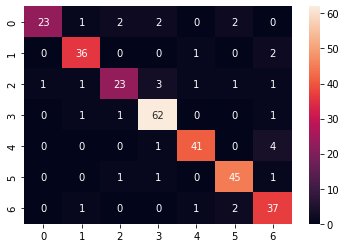

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB

clf1 = SVC(kernel='linear', probability=True)
clf2 = MultinomialNB(alpha=0.01)
clf3 = LogisticRegression(random_state=0, C=10, max_iter=1000)
clf4 = KNeighborsClassifier(n_neighbors=15)

vote_clf = VotingClassifier(estimators=[('svc', clf1), ('mnb', clf2), ('lr', clf3), ('knn', clf4)], voting='soft')

vote_clf = vote_clf.fit(X_train_tfidf, trainY)

y_pred_vote = vote_clf.predict(X_test_tfidf)
score_vote = accuracy_score(testY, y_pred_vote)

print(score_vote)
print(classification_report(testY, vote_clf.predict(X_test_tfidf)))

cm = confusion_matrix(testY, y_pred_vote)

sns.heatmap(cm, annot=True, fmt="d")

## TFIDF-LOGISTIC REGRESSION MODEL EXPLAINABILITY

In [ ]:
!pip install shap
import shap

In [62]:
explainer = shap.LinearExplainer(lr_model_tf, masker=shap.maskers.Independent(X_train_tfidf))

shap_values = explainer.shap_values(X_test_tfidf)

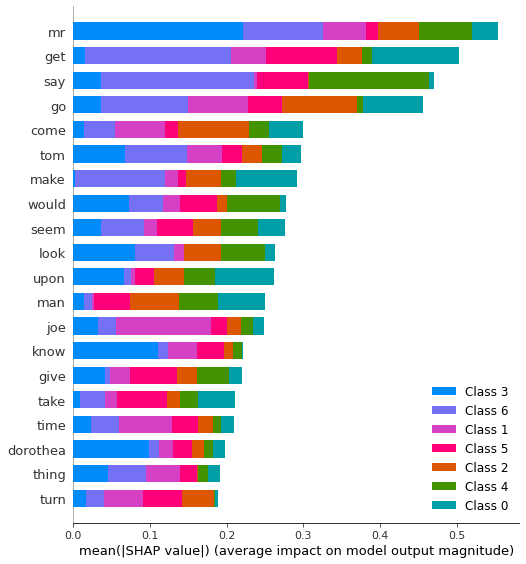

In [63]:
shap.summary_plot(shap_values, X_test_tfidf, feature_names=tfidf.get_feature_names_out())


In [14]:
decodedY

array(['Arthur Conan Doyle', 'Charles Dickens', 'Edgar Allan Poe',
       'George Eliot', 'Jack London', 'Jane Austin', 'Mark Twain'],
      dtype=object)

In [15]:

shap.initjs()
ind = 9
author_index = 3

shap.force_plot(
explainer.expected_value[author_index], shap_values[author_index][ind,:], X_test_tfidf.toarray()[ind,:],
feature_names=tfidf.get_feature_names_out()
)

### TRANSFORMER MODEL 

In [ ]:
!pip install datasets transformers[sentencepiece]

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
import transformers

In [18]:
def prepare_data(X, y):
    data = []
    for i, (sequence, label) in enumerate(zip(X, y)):
        data.append(
        {"paragraph":sequence,
        "label":label,
        "idx":i
        })
        df = pd.DataFrame(data)
    return Dataset.from_pandas(df)

In [19]:
authors_dataset = DatasetDict()

authors_dataset["train"] = prepare_data(trainX, trainY)
authors_dataset["validation"] = prepare_data(testX, testY)

In [20]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["paragraph"], truncation=True)

tokenized_datasets = authors_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
columns=["attention_mask", "input_ids", "token_type_ids"],
label_cols=["labels"],
shuffle=True,
collate_fn=data_collator,
batch_size=16,
)

tf_validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
columns=["attention_mask", "input_ids", "token_type_ids"],
label_cols=["labels"],
shuffle=False,
collate_fn=data_collator,
batch_size=16,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=7)
from tensorflow.keras.optimizers.schedules import PolynomialDecay


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [22]:
batch_size = 16
num_epochs = 5
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs

lr_scheduler = PolynomialDecay(
initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [23]:
import tensorflow as tf

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=7)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model_history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
43/43 [==============================] - 79s 1s/step - loss: 1.7551 - accuracy: 0.3358 - val_loss: 1.4126 - val_accuracy: 0.5300
Epoch 2/5
43/43 [==============================] - 46s 1s/step - loss: 1.0180 - accuracy: 0.7311 - val_loss: 0.8031 - val_accuracy: 0.8233
Epoch 3/5
43/43 [==============================] - 45s 1s/step - loss: 0.4573 - accuracy: 0.9113 - val_loss: 0.5706 - val_accuracy: 0.8300
Epoch 4/5
43/43 [==============================] - 44s 1s/step - loss: 0.2299 - accuracy: 0.9680 - val_loss: 0.5370 - val_accuracy: 0.8300
Epoch 5/5
43/43 [==============================] - 44s 1s/step - loss: 0.1532 - accuracy: 0.9898 - val_loss: 0.5171 - val_accuracy: 0.8267


### TRANSFORMERS MODEL EXPLAINABILITY

In [66]:
import transformers

pipeline_distilbert = transformers.pipeline("text-classification", model=model, tokenizer=AutoTokenizer.from_pretrained("distilbert-base-uncased"), device=0, return_all_scores=True)

explainer_distilbert = shap.Explainer(pipeline_distilbert)

shap_values = explainer_distilbert(testX[14:17])
shap.plots.text(shap_values)

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [01:15<00:00, 16.73s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 4it [01:48, 36.02s/it]


In [25]:
decodedY

array(['Arthur Conan Doyle', 'Charles Dickens', 'Edgar Allan Poe',
       'George Eliot', 'Jack London', 'Jane Austin', 'Mark Twain'],
      dtype=object)